<a href="https://colab.research.google.com/github/mrodriguezh23/Proteccion-De-Datos/blob/main/Rodriguez_Hernandez_Miriam_LaboratorioPix2Pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Conexion con Google Drive**

In [ ]:
from google.colab import drive # Este sirve para montar Google Drive en el
# entorno de Google Colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%tensorflow_version 2.x # Este es una instrucción específica de Colab para
# garantizar que la versión de TensorFlow utilizada sea la 2.x.

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


### **Proyecto de Flores más nítidas con ayuda de la Arquitectura Px2Pix**

Establecer las rutas de los repositorios de los Data set de las Imagenes así como el Preprocesamiento de detección de las mismas.

In [ ]:
# Importa las bibliotecas necesarias, incluyendo TensorFlow para el aprendizaje
# profundo, Matplotlib para visualización, y NumPy para operaciones numéricas
# eficientes.

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Ruta raiz
PATH = "/content/drive/MyDrive/Aprendizaje_Profundo"

# Ruta de datos de entrada
INPATH = PATH + '/InputFlores'
# Ruta de datos de salida
OUPATH = PATH + '/TargetFlores'
# Ruta de los checkpoints
CKPATH = PATH + '/checkpoints'

 # Obtención de imágenes en la carpeta de entrada:
imgurls = !ls -1 "{INPATH}" # Utiliza la magia de la shell (!ls -1 "{INPATH}")
# para obtener la lista de nombres de archivos en la carpeta InputFlores y
# guarda estos nombres en la variable imgurls.

# Definición de variables para el tamaño del conjunto de datos
n = 400
train_n = round(n * 0.80)
# Establece el tamaño total del conjunto de datos (n) y luego calcula el tamaño
# del conjunto de entrenamiento (train_n) como el 80% de n.

# Randomización de la lista de URLs de imágenes
randurls = np.copy(imgurls)
np.random.seed(23) # Importante : sólo para el tutorial.
np.random.shuffle(randurls)
# Crea una copia de la lista de URLs de imágenes (randurls) y la baraja de
# manera aleatoria usando np.random.shuffle. Se utiliza una semilla
# (np.random.seed(23)) para reproducibilidad.

# Partición del conjunto de datos en entrenamiento y prueba:
tr_urls = randurls[:train_n]
ts_urls = randurls[train_n:n]
# Divide la lista aleatorizada en dos conjuntos: uno de entrenamiento (tr_urls)
# y otro de prueba (ts_urls), utilizando el tamaño calculado previamente.

# Impresión de la longitud de las listas:
print(len(imgurls), len(tr_urls), len(ts_urls))

8189 320 80


Empezamos a usar TensorFlow para procesar el tamaño y ajustando las dimensiones de las imagenes.
De esta forma se normalizará, si le restamos -1 estará

En el paper recomiendan usar random_jitter, y se aplicaran transformaciones aleatorias para poder generar más margaritas, o tulipanes, u otro tipo de flores, desplazando la imagen, haciendo una ampliación de 286 y con la imagen de 256 se puedo hacer un cropp para trasladarla un poco o rotarla.
Así para las dos imagenes, y luego superponerla, con la funcion tensor Flow stack, de esta manera las apila. Así se tendría un objeto tridimensional de 256 x 256.
Al invocarla hace un recorte aleatorio.
Wow, 256x256x 3 canales de color es lo que trabajaremos en la imagen y con un escalar aleatorio la podemos rotar o dejarla como esá.
Todo eso para determinar la aumentación de datos.

Las funciones para cargar las imagenes se establecen para el input y para el target, con ello se pasara el nombre de archivo y es necesario para cada una de las carpetas y así se pueda hacer correctamente.
El cast es para formato decimal y no números enteros.

In [ ]:
# Definición de dimensiones de la imagen
IMG_WIDTH = 256
IMG_HEIGHT = 256


# Función de reescalado
def resize(inimg, tgimg, height, width):

  inimg = tf.image.resize(inimg, [height, width])
  tgimg = tf.image.resize(tgimg, [height, width])

  return inimg, tgimg
  # Esta función toma dos imágenes (input y target) y las redimensiona a las
  # dimensiones especificadas.


# Función de normalización:
# Normaliza al rango [-1, +1] la imagen.
def normalize(inimg, tgimg):
  inimg = (inimg / 127.5) - 1
  tgimg = (tgimg / 127.5) - 1

  return inimg, tgimg


# Función de aumentación de datos (random jitter)
@tf.function()
# Aumentación de datos : Random Crop + Flip.
def random_jitter(inimg, tgimg):

  inimg, tgimg = resize(inimg, tgimg, 286, 286)

  stacked_image = tf.stack([inimg, tgimg], axis=0)
  cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  inimg, tgimg = cropped_image[0], cropped_image[1]

  if tf.random.uniform(()) > 0.5:

    inimg = tf.image.flip_left_right(inimg)
    tgimg = tf.image.flip_left_right(tgimg)

  return inimg, tgimg
  # Esta función realiza aumentación de datos mediante un recorte aleatorio y,
  # con probabilidad del 50%, voltea horizontalmente las imágenes.


# Función de carga de imagen
def load_image(filename, augment=True):

  inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + filename)), tf.float32)[..., :3]
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUPATH + '/' + filename)), tf.float32)[..., :3]

  inimg, tgimg = resize(inimg, tgimg, IMG_HEIGHT, IMG_WIDTH)

  if augment:
    inimg, tgimg = random_jitter(inimg, tgimg)

  inimg, tgimg = normalize(inimg, tgimg)

  return inimg, tgimg
# Esta función carga una imagen dada su filename. Lee las imágenes input y
# target desde las rutas especificadas (INPATH y OUPATH), las redimensiona y
# normaliza. Si augment es True, aplica aumentación de datos mediante la función
# random_jitter.

# Funciones de carga de imágenes de entrenamiento y prueba
def load_train_image(filename):
  return load_image(filename, True)

def load_test_image(filename):
  return load_image(filename, False)

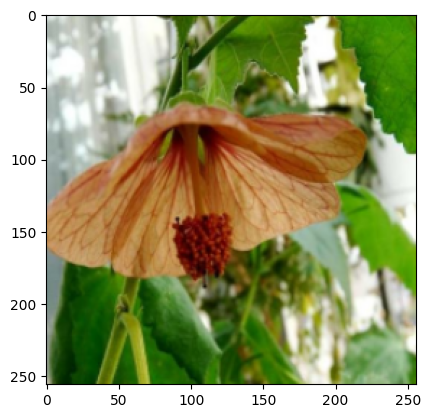

In [ ]:
# Visualización de una imagen de entrenamiento después del preprocesamiento
plt.imshow(((load_train_image(randurls[0])[1])+1)/2)
# Se visualiza una imagen de entrenamiento después del preprocesamiento.
# La expresión ((load_train_image(randurls[0])[1])+1)/2 revierte la
# normalización para que la imagen sea visualizable.

La imagen desplegada es la primera imagen de entrenamiento después de haber pasado por el preprocesamiento. La visualización final debería mostrar esta imagen de manera que sea interpretable, ya que se ha revertido parcialmente la normalización para que los valores estén en el rango [0, 1].

### **Entrenamiento**

Usó el dataset de tensorflow, apartir de un listado de objetos que se le indique, que es un listado de nombres de archivos, así estas funciones se usaran los tensores con la ayuda de las funciones previamente.
La funcion map hace el mapeo de filenames con la función load_train_image.
Se usa la propiedad de procesamientos en paralelos como CPUS tenga el ordenador, y se aplica de forma automatica con AUTOTUNE.
Se puede tambien implmentar diferentes tamaños de lote para el uso en el procesamiento. Dejo 1 por que lo especifican en el paper entonces se usa así.


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(load_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)

Por ejemplo establezco un lote de 6 imagenes como se muestra a continuación

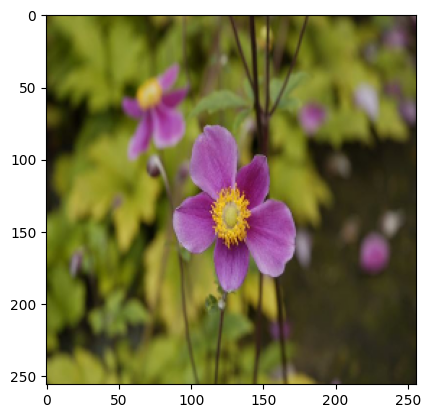

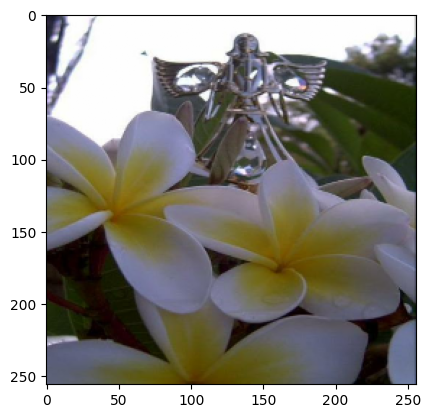

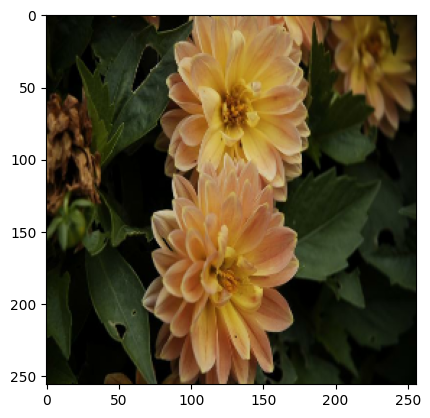

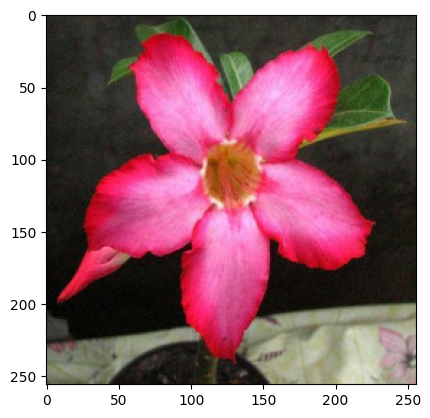

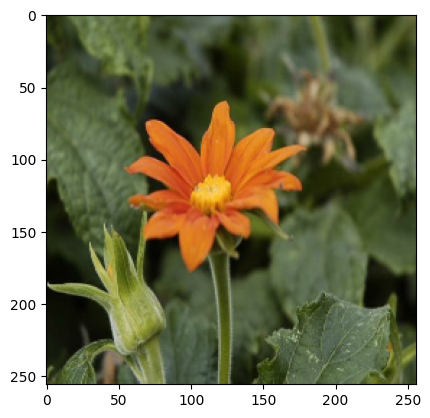

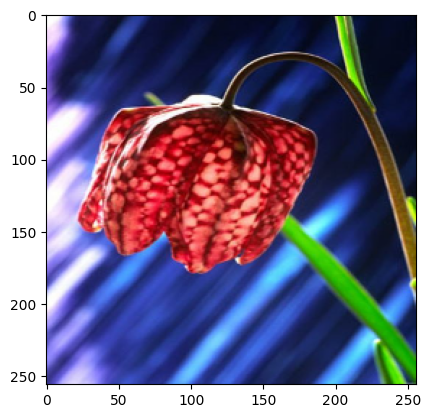

In [ ]:
for inimg, reimg in test_dataset.take(6):
  plt.imshow((reimg[0]+1)/2)
  plt.show()

Hasta aquí se termina la parte de carga de imagenes

## Aplicar la red Neuronal con la arquitectura Pix2Pix

Función para Diseñar nuestro Encoder.
Es de gran ayuda el paper ya que tiene un apartado en donde especifican como es la red generadora y la red discriminadora vienen implementadas.

In [ ]:
from tensorflow.keras import *
from tensorflow.keras.layers import *

def downsample(filters, apply_batchnorm=True):

  result = Sequential()

  initializer = tf.random_normal_initializer(0, 0.02)

  # Capa convolucional.
  result.add(Conv2D(filters,
                    kernel_size=4,
                    strides=2,
                    padding="same",
                    kernel_initializer=initializer,
                    use_bias=not apply_batchnorm))

  if apply_batchnorm:
    # Capa de BatchNorm.
    result.add(BatchNormalization())

  # Capa de activación.
  result.add(LeakyReLU())

  return result

downsample(64)

Función para el Decoder.
El parametro de "use_bias" se pone en Falso por que no ocuparemos el sesgo.

In [ ]:
def upsample(filters, apply_dropout=False):

  result = Sequential()

  initializer = tf.random_normal_initializer(0, 0.02)

  # Capa convolucional Inversa
  result.add(Conv2DTranspose(filters,
                             kernel_size=4,
                             strides=2,
                             padding="same",
                             kernel_initializer=initializer,
                             use_bias=False))


  # Capa de BatchNorm.
  result.add(BatchNormalization())

  if apply_dropout:
    # Capa de Dropout. Desconectar aleatoriamente
    result.add(Dropout(0.5))

  # Capa de activación.
  result.add(ReLU())

  return result

upsample(64)

Hasta aquí tengo la capa de la Arquitectura.

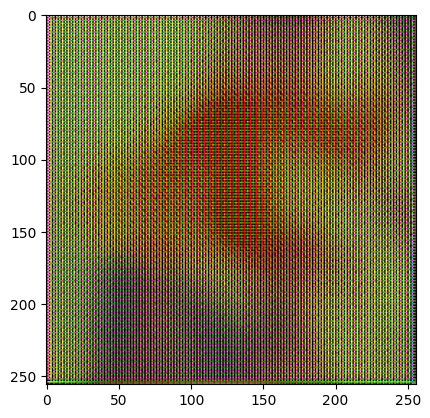

In [ ]:
def Generator():

  inputs = tf.keras.layers.Input(shape=[None,None,3])

  down_stack = [
    downsample(64, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128),                       # (bs, 64,  64,  128)
    downsample(256),                       # (bs, 32,  32,  256)
    downsample(512),                       # (bs, 16,  16,  512)
    downsample(512),                       # (bs, 8,   8,   512)
    downsample(512),                       # (bs, 4,   4,   512)
    downsample(512),                       # (bs, 2,   2,   512)
    downsample(512),                       # (bs, 1,   1,   512)
  ]

  up_stack = [
    upsample(512, apply_dropout=True),     # (bs, 2,   2,   1024)
    upsample(512, apply_dropout=True),     # (bs, 4,   4,   1024)
    upsample(512, apply_dropout=True),     # (bs, 8,   8,   1024)
    upsample(512),                         # (bs, 16,  16,  1024)
    upsample(256),                         # (bs, 32,  32,  512)
    upsample(128),                         # (bs, 64,  64,  256)
    upsample(64),                          # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0, 0.02)

  last = Conv2DTranspose(filters = 3,
                         kernel_size = 4,
                         strides = 2,
                         padding = "same",
                         kernel_initializer = initializer,
                         activation = "tanh")

  x = inputs
  s = []

  concat = Concatenate()

  for down in down_stack:
    x = down(x)
    s.append(x)

  s = reversed(s[:-1])

  for up, sk in zip(up_stack, s):

    x = up(x)
    x = concat([x, sk])

  last = last(x)

  return Model(inputs=inputs, outputs=last)


for inimg, tgimg in train_dataset.take(1):
  generator = Generator()
  gen_output = generator((inimg+1) * 127.5, training=False)
  plt.imshow(gen_output[0])

TensorShape([1, 16, 16, 1])

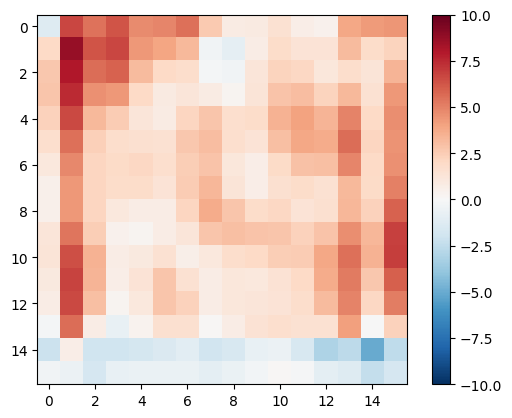

In [ ]:
def Discriminator():

  ini = Input(shape=[None, None, 3], name="input_img")
  gen = Input(shape=[None, None, 3], name="gener_img")

  con = concatenate([ini, gen])

  initializer = tf.random_normal_initializer(0, 0.02)

  down1 = downsample(64, apply_batchnorm=False)(con)
  down2 = downsample(128)(down1)
  down3 = downsample(256)(down2)
  down4 = downsample(512)(down3)

  last = tf.keras.layers.Conv2D(filters=1,
                                kernel_size=4,
                                strides=1,
                                kernel_initializer=initializer,
                                padding="same")(down4)

  return tf.keras.Model(inputs=[ini, gen], outputs=last)

discriminator = Discriminator()
discr_output = discriminator([(inimg+1)*127.5, gen_output], training=False)
plt.imshow(discr_output[0,:,:,0], vmin=-10, vmax=10, cmap='RdBu_r')
plt.colorbar()
discr_output.shape

Diseñar una función de coste adversaria para que compitan en el entrenamiento.

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):

  # Diferencia entre los true por ser real y el detectado por el discriminador.
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  # Diferencia entre los false por ser generado y el detectado por el discriminador.
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

La evaluación del generador es diferente, ya que la imagen debe de identificar que es la flor indicada, es decir, la imagen real de la imagen que se a generado.

In [ ]:
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):

  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss

In [ ]:
import os

generator_optimizer     = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

generator = Generator()
discriminator = Discriminator()

checkpoint_prefix = os.path.join(CKPATH, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def generate_images(model, test_input, tar, save_filename=False, display_imgs=True):

  prediction = model(test_input, training=True)

  if save_filename:
    tf.keras.preprocessing.image.save_img(PATH + '/outputFlores/' + save_filename + '.jpg', prediction[0,...])

  plt.figure(figsize=(10,10))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  if display_imgs:
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      # getting the pixel values between [0, 1] to plot it.
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')

  plt.show()

In [ ]:
@tf.function()
def train_step(input_image, target):

  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:

    output_image = generator(input_image, training=True)

    output_gen_discr = discriminator([output_image, input_image], training=True)

    output_trg_discr = discriminator([target, input_image], training=True)

    discr_loss = discriminator_loss(output_trg_discr, output_gen_discr)

    gen_loss = generator_loss(output_gen_discr, output_image, target)


    generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)

    discriminator_grads = discr_tape.gradient(discr_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))

In [ ]:
from IPython.display import clear_output

def train(dataset, epochs):
  for epoch in range(epochs):

    imgi = 0
    for input_image, target in dataset:
      print('epoch ' + str(epoch) + ' - train: ' + str(imgi)+'/'+str(len(tr_urls)))
      imgi +=1
      train_step(input_image, target)

      clear_output(wait=True)

    for inp, tar in test_dataset.take(5):
      generate_images(generator, inp, tar, str(imgi) + '_' + str(epoch), display_imgs=True)

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 1 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

### **Imagenes Mejoradas**

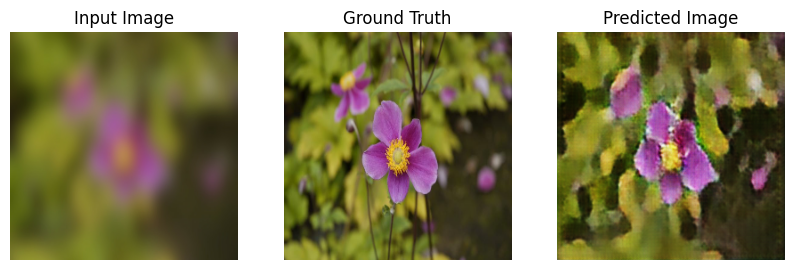

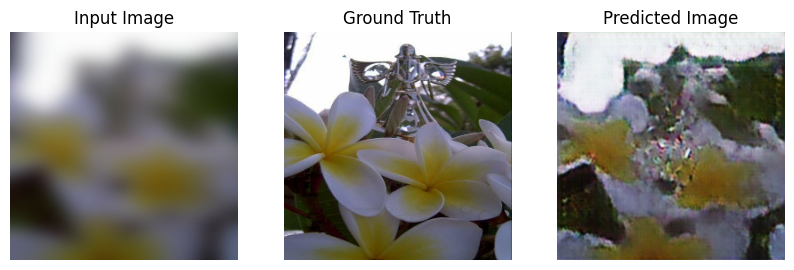

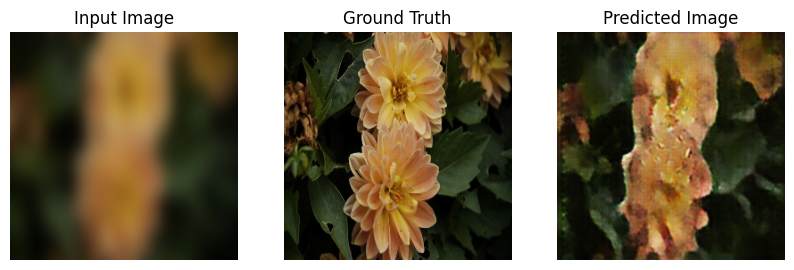

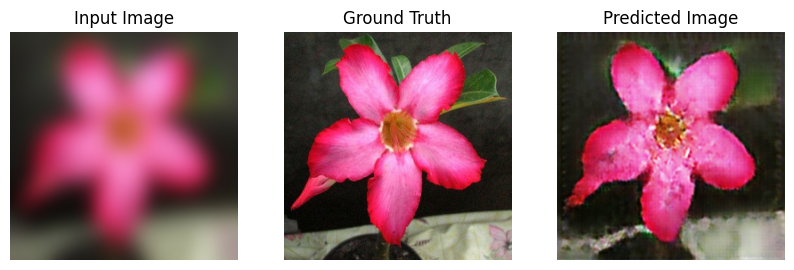

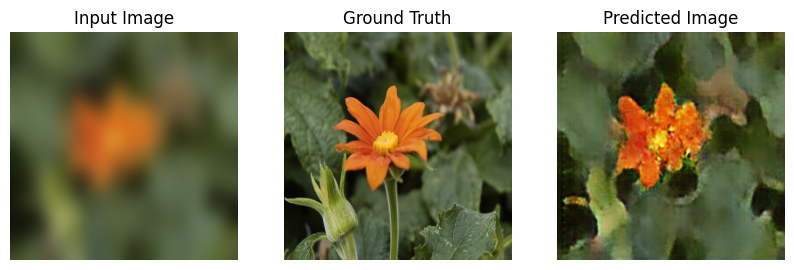

Tiempo de ejecución: 412.2808289527893 segundos


In [ ]:
import time

start_time = time.time()


train(train_dataset, 10)


end_time = time.time()
execution_time = end_time - start_time
print(f"Tiempo de ejecución: {execution_time} segundos")


In [ ]:
#Para reiniciar
#checkpoint.restore(tf.train.latest_checkpoint(CKPATH)).assert_consumed()

In [ ]:
import os

def convert_bytes(size, unit=None):
    # Convertir bytes a la unidad especificada
    units = {'B': 1, 'KB': 1024, 'MB': 1024 ** 2, 'GB': 1024 ** 3}
    size_in_unit = size / units[unit]
    return size_in_unit

def get_size_and_count(folder_path):
    # Obtener el tamaño y contar el número de archivos
    size = sum(os.path.getsize(os.path.join(folder_path, f)) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)))
    num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    return size, num_files

# Definir la ruta base
base_path = "/content/drive/MyDrive/Aprendizaje_Profundo"

# Lista de carpetas
folders = ["InputFlores", "TargetFlores", "checkpoints", "outputFlores"]

# Recorrer cada carpeta
for folder in folders:
    # Ruta completa de la carpeta
    folder_path = os.path.join(base_path, folder)

    # Obtener el tamaño y contar el número de archivos
    size, num_files = get_size_and_count(folder_path)

    # Convertir el tamaño a MB o GB según corresponda
    if size >= 1024 ** 3:
        size_str = f"{convert_bytes(size, 'GB'):,.2f} GB"
    elif size >= 1024 ** 2:
        size_str = f"{convert_bytes(size, 'MB'):,.2f} MB"
    else:
        size_str = f"{convert_bytes(size, 'KB'):,.2f} KB"

    # Mostrar resultados
    print(f"Carpeta: {folder}")
    print(f"Tamaño: {size_str}")
    print(f"Número de archivos: {num_files}")
    print("----------------------------------")


Carpeta: InputFlores
Tamaño: 233.15 MB
Número de archivos: 8189
----------------------------------
Carpeta: TargetFlores
Tamaño: 331.01 MB
Número de archivos: 8199
----------------------------------
Carpeta: checkpoints
Tamaño: 12.78 GB
Número de archivos: 41
----------------------------------
Carpeta: outputFlores
Tamaño: 97.15 KB
Número de archivos: 10
----------------------------------
